In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation

import torch
import torch.nn

import torchsummary


from tqdm.notebook import tqdm

import constant
import model
import simulation
import visual
import loss

print(constant.device)

torch.manual_seed(0)
np.random.seed(0)

cpu


# Model Definitions

In [21]:
model_o = model.OffenseModel().to(constant.device)
model_d = model.DefenseModel().to(constant.device)

# print('Offensive Coach Model Summary: ')
# torchsummary.summary(model_o, input_size=(11, 2))
# print('Defensive Coach Model Summary: ')
# torchsummary.summary(model_d, input_size=(11, 2))


# Loss Functions

In [13]:

def loss_function_dribble_pass(all_game_states):
    # batch, game_steps, player, pos
    pos_op = all_game_states[:, :, constant.idxs_op, :]
    pos_dp = all_game_states[:, :, constant.idxs_dp, :]
    pos_ball = all_game_states[:, :, constant.idxs_ball, :]
    
    pos_all = all_game_states[:, :, :, :]
    
    dist_ball_op = (pos_ball - pos_op).norm(dim=-1) # batch, game_steps, player
    dist_closest_dribbler, _ = dist_ball_op.min(dim=-1) # batch, game_steps
    dribbling_frames = dist_closest_dribbler <= (constant.radius_player + constant.radius_ball)
#     print(dribbling_frames.shape)
    
    vel = all_game_states[:, 1:, :, :] - all_game_states[:, :-1, :, :]
    speed = vel.norm(dim=-1)
    loss_o = -speed.mean()
    loss_d = -speed.mean()

#     loss_o += pos_all[:, -1, :, :].norm(dim=-1).mean()
#     loss_d += pos_all[:, -1, :, :].norm(dim=-1).mean()
    
    
#     return loss_o, loss_d
    return 0., 0.

def loss_function_shot(last_game_state):
    # batch, player, pos
    pos_op = last_game_state[:, constant.idxs_op, :]
    pos_dp = last_game_state[:, constant.idxs_dp, :]
    pos_ball = last_game_state[:, constant.idxs_ball, :]
    
    dist_op_ball = (pos_op - pos_ball).norm(dim=-1)
    _, idx_ball_handler = dist_op_ball.min(dim=-1)
    
    idx_all_batches = torch.arange(len(last_game_state))
    pos_op_dribbler = pos_op[idx_all_batches, idx_ball_handler] [:, None, :]
    
    
    ppp = loss.points_per_possession(pos_op_dribbler, pos_dp)
    ppp = ppp.mean()
    return -ppp, ppp

def loss_function(all_game_states):
    # batch, game_steps, player, pos
    loss_o, loss_d = 0., 0.
    
    loss_dp_o, loss_dp_d = loss_function_dribble_pass(all_game_states)
    loss_shot_o, loss_shot_d = loss_function_shot(all_game_states[:, -1, :, :])
    
    loss_o += loss_dp_o + loss_shot_o
    loss_d += loss_dp_d + loss_shot_d
    return loss_o, loss_d



# Optimization

O Loss: -1.1505886316299438, D Loss: 1.1505886316299438



<IPython.core.display.Javascript object>


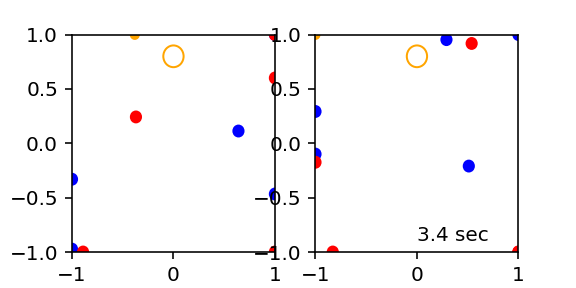

In [15]:
init_game_state = constant.random_initial_game_state(batch_size=2)
all_game_states = simulation.run_simulation(model_o, model_d, init_game_state, pbar=tqdm())

loss_o, loss_d = loss_function(all_game_states)
print(f'O Loss: {loss_o.item()}, D Loss: {loss_d.item()}')


%matplotlib notebook
anim = visual.show_game_animation(all_game_states)

In [18]:
batch_size = 19

opt_o = torch.optim.Adam(model_o.parameters())
opt_d = torch.optim.Adam(model_d.parameters())


losses_o, losses_d = [], []


total_pbar = tqdm(range(200), desc='Epochs')

for epoch in total_pbar:
    init_game_state = constant.random_initial_game_state(batch_size=batch_size)
    
    all_game_states = simulation.run_simulation(model_o, model_d, init_game_state, with_grad=True)
    
    loss_o, loss_d = loss_function(all_game_states)
    
    
    opt_o.zero_grad()
    opt_d.zero_grad()
    grad_o = torch.autograd.grad(loss_o, model_o.parameters(), retain_graph=True)
    grad_d = torch.autograd.grad(loss_d, model_d.parameters())
    for i, params in enumerate(model_o.parameters()):
        params.grad = grad_o[i]

    for i, params in enumerate(model_d.parameters()):
        params.grad = grad_d[i]
    
    opt_o.step()
    opt_d.step()
    
    total_pbar.set_postfix({'O Loss': loss_o.item(), 'D Loss': loss_d.item()})
    losses_o.append(loss_o)
    losses_d.append(loss_d)
    

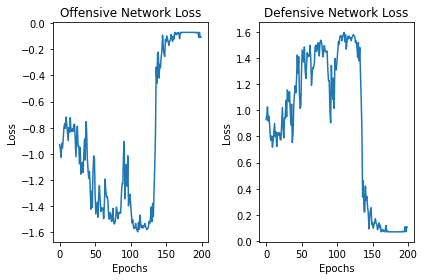

In [19]:
%matplotlib inline

plt.subplot(121)
plt.plot(np.arange(len(losses_o)), losses_o)
plt.title('Offensive Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(np.arange(len(losses_d)), losses_d)
plt.title('Defensive Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

O Loss: -0.07122394442558289, D Loss: 0.07122394442558289



<IPython.core.display.Javascript object>


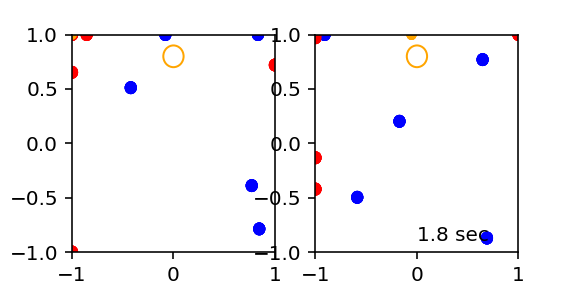

In [20]:
init_game_state = constant.random_initial_game_state(batch_size=2)
all_game_states = simulation.run_simulation(model_o, model_d, init_game_state, pbar=tqdm())

loss_o, loss_d = loss_function(all_game_states)
print(f'O Loss: {loss_o.item()}, D Loss: {loss_d.item()}')


%matplotlib notebook
anim = visual.show_game_animation(all_game_states)